# Ensemble model: averaging predictions of GRU and DLinear
Both trained on normalized data
final predictions are summed with the predicted median

## Dataset Loading and Libraries

In [1]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
os.environ['TF_GPU_THREAD_MODE']="gpu_private"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
np.random.seed(seed)
from scipy.interpolate import interp1d
import logging
import gc
import random
random.seed(seed)
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as pyplot
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import backend as K
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
#tf.keras.backend.set_floatx('float16')
tf.function(jit_compile=True)
tf.keras.backend.floatx()

2.13.0


'float32'

In [21]:
def build_sequences_filtered(target_data, valid_periods, window=200, stride=50, telescope=18):
    assert window % stride == 0
    outlier_detection_length = 50
    delta = 0.0001
    outliers = []
    dataset = []
    labels = []
    for i, signal in enumerate(target_data):
        if valid_periods[i][1]-valid_periods[i][0] >= telescope*2:
            for j in np.arange(min(valid_periods[i][0],len(signal)-window-telescope),len(signal)-window-telescope,stride):
                input_sequence = signal[j:j+window]
                output_sequence = signal[j+window:j+window+telescope]
                #grad_less_delta = np.abs(np.ediff1d(input_sequence)) < delta
                #grad_less_delta = np.abs(np.gradient(input_sequence)) < delta
                # Now we have an array of 0s and 1s
                #temp = np.diff(np.where(np.concatenate(([grad_less_delta[0]],grad_less_delta[:-1] != grad_less_delta[1:],[True])))[0])[::2]
                # If temp contains at least one value that is greater than outlier_detection_length, then we have an outlier
                #if np.any(temp > outlier_detection_length):# or in_iqr==0 or out_iqr==0:
                    #outliers.append(i)
                #else:
                dataset.append(input_sequence)
                labels.append(output_sequence)
    dataset = np.array(dataset)
    labels = np.array(labels)
    medians = np.median(dataset,axis=1)
    median_labels_telescope = np.median(labels,axis=1)
    print(len(outliers))
    return dataset, labels, medians, median_labels_telescope#, iqr_X, iqr_y

In [22]:
telescope = 18
batch_size = 128
epochs = 200
window = 200
stride = 10
data = np.load("/kaggle/input/timeseries/training_data.npy")
categories = np.load("/kaggle/input/timeseries/categories.npy")
valid_periods = np.load("/kaggle/input/timeseries/valid_periods.npy")
X, y, median_X, median_y = build_sequences_filtered(data, valid_periods, window, stride, telescope)
norm_X, norm_y = (X-median_X[:,None]), (y-median_y[:,None])#/iqr_y[:,None]
print(X.shape, y.shape)

0
(219985, 200) (219985, 18)


## Detecting outliers and splits

In [5]:
max_telescope_grads = np.abs(np.diff(y,axis=1))
count_telescope = np.sum(max_telescope_grads >= 0.6, axis=1)
print(count_telescope.shape)
indices_telescope = np.where((count_telescope!=1))[0]
max_window_grads = np.abs(np.diff(X,axis=1))
count_window = np.sum(max_window_grads >= 0.6, axis = 1)
indices_window = np.where((count_window > 2) | (count_window < 1))[0]

idx = np.intersect1d(indices_window, indices_telescope)
print("outliers window:",len(X)-len(indices_window))
print("outliers telscope:",len(y)-len(indices_telescope))
print("total intersect outliers:", len(y)-len(idx))
np.where((count_telescope==1))[0][40:80]

(219527,)
outliers window: 8012
outliers telscope: 924
total intersect outliers: 8760


array([14380, 14381, 15340, 15341, 15379, 15380, 15391, 15392, 15599,
       15628, 16327, 16438, 17693, 17694, 17739, 17740, 19815, 19816,
       20167, 20168, 20347, 20515, 20518, 20519, 21084, 21085, 22258,
       22260, 22262, 22263, 22269, 22270, 23012, 23013, 23830, 23831,
       25171, 25347, 25356, 25357])

In [6]:
max_telescope_grads = np.max(np.abs(np.diff(y,axis=1)),axis=1)
max_window_grads = np.max(np.abs(np.diff(X,axis=1)),axis=1)
indices = np.where((max_telescope_grads >= 1.8*max_window_grads) & (max_window_grads>=0.2))[0]
constant_samples_mask = np.all(y[:, 1:] == y[:, :-1], axis=1)
# Get indices of constant samples
constant_telescope_indices = np.where(constant_samples_mask)[0]
#idx = np.intersect1d(indices_window, indices_telescope)
print("outliers window:",len(indices))
print("outliers telscope:",len(indices))
print("total intersect outliers:", len(indices))
print("total constant telescopes: ",len(constant_telescope_indices))
indices, constant_telescope_indices

outliers window: 470
outliers telscope: 470
total intersect outliers: 470
total constant telescopes:  93


(array([  4267,   4268,   4318,   4319,   5510,   5511,   6094,   6095,
          6155,   6156,   6964,   7788,   8656,   8657,  10285,  10286,
         10620,  10621,  10767,  14380,  14381,  14397,  14398,  15651,
         16671,  23344,  23345,  23448,  23449,  23830,  23831,  25266,
         25423,  25429,  25430,  25469,  25470,  25628,  25776,  25922,
         25923,  26062,  27628,  27629,  27759,  27760,  29341,  29342,
         29375,  29376,  31027,  31028,  31036,  31037,  31290,  31738,
         34697,  34698,  35936,  35959,  35960,  35973,  36196,  36197,
         36222,  36250,  36251,  36278,  36279,  36331,  36443,  36444,
         37155,  37156,  37714,  37846,  38097,  38101,  38302,  38303,
         38311,  38418,  38482,  38558,  41310,  41311,  41449,  41450,
         41485,  41994,  42089,  42090,  42355,  42356,  42902,  42903,
         42942,  42948,  42949,  43284,  43298,  43379,  43591,  45332,
         45489,  45517,  45518,  45531,  45670,  45807,  49398, 

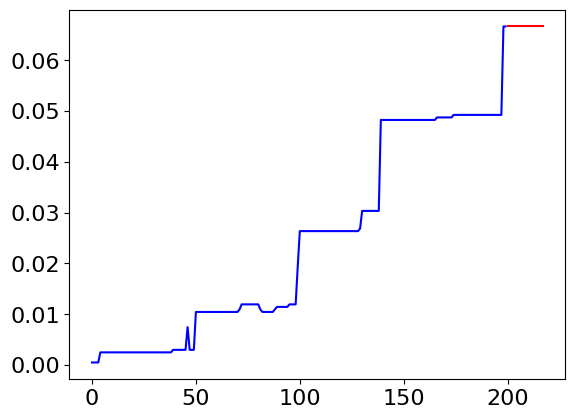

In [105]:
plt.plot(range(200),X[157212],color='blue')
plt.plot(range(200,218),y[157212],color='red')

In [23]:
'''idx = np.union1d(indices, constant_telescope_indices)
idx = np.setdiff1d(range(len(X)), idx)
X=X[idx]
y=y[idx]
median_y = median_y[idx]
median_X = median_X[idx]
norm_X = norm_X[idx]
norm_y = norm_y[idx]'''
X_train, X_val, y_train, y_val, norm_X_train, norm_X_val, norm_y_train, norm_y_val, median_y_train, median_y_val = train_test_split(X, y, norm_X, norm_y, median_y, test_size=0.2, random_state=42)
print(X.shape, y.shape)

(219985, 200) (219985, 18)


## DLinear

In [24]:
class DLinear(tfk.models.Model):
    def __init__(self, output_steps, kernel_size=25, **kwargs):
        super(DLinear, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.output_steps = output_steps
        self.kernel_initializer = "he_normal"
        
    def build(self, input_shape):
        self.built_input_shape = input_shape
        #self.td1 = tfkl.Dense(512,kernel_initializer=self.kernel_initializer,name="trend_dense")
        #self.rd1 = tfkl.Dense(512,kernel_initializer=self.kernel_initializer,name="residual_dense")
        self.trend_dense = tfkl.Dense(self.output_steps,kernel_initializer=self.kernel_initializer,name="trend_recomposer")
        self.residual_dense = tfkl.Dense(self.output_steps,kernel_initializer=self.kernel_initializer,name="residual_recomposer")
        super(DLinear, self).build(input_shape)
        
    def call(self, inputs):
        trend_input = tf.expand_dims(inputs,axis=-1)
        trend = tfkl.AveragePooling1D(pool_size=self.kernel_size,strides=1,padding="same",name="trend_decomposer")(trend_input)
        trend = tf.squeeze(trend,axis=-1)
        residual = tfkl.Subtract(name="residual_decomposer")([inputs, trend])
        
        #trend = self.td1(trend)
        #residual = self.rd1(residual)
        
        residual = self.residual_dense(residual)
        trend = self.trend_dense(trend)
        add = tfkl.Add(name="recomposer")([residual, trend])
        return add
    
    def summary(self):
        if self.built:
            self.model().summary()
        else:
            super().summary()
            
    def model(self):
        x = tfkl.Input(shape=(self.built_input_shape[1:]))
        model = tfk.models.Model(inputs=[x],outputs=self.call(x))
        return model

In [26]:
model_dlinear = DLinear(telescope, kernel_size=25)
model_dlinear.build((None,window))
model_dlinear.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'], optimizer=tf.keras.optimizers.Adam(1e-3))
model_dlinear.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 tf.expand_dims_1 (TFOpLamb  (None, 200, 1)               0         ['input_2[0][0]']             
 da)                                                                                              
                                                                                                  
 trend_decomposer (AverageP  (None, 200, 1)               0         ['tf.expand_dims_1[0][0]']    
 ooling1D)                                                                                        
                                                                                            

## Median regressor (dense)

In [25]:
median_regressor = tfk.Sequential()
median_regressor.add(tfkl.Dense(200, activation = 'relu', input_shape=(200,)))
median_regressor.add(tfkl.Dense(400, activation='relu'))
median_regressor.add(tfkl.Dense(400, activation='relu'))
median_regressor.add(tfkl.Dense(200, activation='relu'))
median_regressor.add(tfkl.Dense(1, activation='sigmoid'))
median_regressor.compile(optimizer=tf.keras.optimizers.AdamW(1e-3), loss='mean_squared_error', metrics=['mae'])  # Using mean squared error as the loss function
median_regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 200)               40200     
                                                                 
 dense_7 (Dense)             (None, 400)               80400     
                                                                 
 dense_8 (Dense)             (None, 400)               160400    
                                                                 
 dense_9 (Dense)             (None, 200)               80200     
                                                                 
 dense_10 (Dense)            (None, 1)                 201       
                                                                 
Total params: 361401 (1.38 MB)
Trainable params: 361401 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training of DLinear and Median predictor

In [27]:
# Train the model
history = model_dlinear.fit(
    x = norm_X_train,
    y = norm_y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(norm_X_val,norm_y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, min_delta=1e-5, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.1)
    ]
).history

Epoch 1/200
1375/1375 [==============================] - 7s 4ms/step - loss: 0.0053 - mae: 0.0452 - val_loss: 0.0043 - val_mae: 0.0411 - lr: 0.0010
Epoch 2/200
1375/1375 [==============================] - 5s 4ms/step - loss: 0.0043 - mae: 0.0406 - val_loss: 0.0043 - val_mae: 0.0407 - lr: 0.0010
Epoch 3/200
1375/1375 [==============================] - 5s 4ms/step - loss: 0.0043 - mae: 0.0406 - val_loss: 0.0043 - val_mae: 0.0405 - lr: 0.0010
Epoch 4/200
1375/1375 [==============================] - 5s 4ms/step - loss: 0.0043 - mae: 0.0407 - val_loss: 0.0043 - val_mae: 0.0412 - lr: 0.0010
Epoch 5/200
1375/1375 [==============================] - 5s 4ms/step - loss: 0.0043 - mae: 0.0407 - val_loss: 0.0044 - val_mae: 0.0413 - lr: 0.0010
Epoch 6/200
1375/1375 [==============================] - 5s 4ms/step - loss: 0.0042 - mae: 0.0397 - val_loss: 0.0042 - val_mae: 0.0400 - lr: 1.0000e-04
Epoch 7/200
1375/1375 [==============================] - 5s 4ms/step - loss: 0.0042 - mae: 0.0397 - val_loss

In [28]:
# Train the median regressor
history = median_regressor.fit(
    x = X_train,
    y = median_y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val,median_y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, min_delta=5e-6, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.1)
    ]
).history

Epoch 1/200
1375/1375 [==============================] - 9s 5ms/step - loss: 0.0081 - mae: 0.0628 - val_loss: 0.0067 - val_mae: 0.0563 - lr: 0.0010
Epoch 2/200
1375/1375 [==============================] - 6s 5ms/step - loss: 0.0067 - mae: 0.0567 - val_loss: 0.0064 - val_mae: 0.0539 - lr: 0.0010
Epoch 3/200
1375/1375 [==============================] - 7s 5ms/step - loss: 0.0064 - mae: 0.0550 - val_loss: 0.0064 - val_mae: 0.0541 - lr: 0.0010
Epoch 4/200
1375/1375 [==============================] - 6s 5ms/step - loss: 0.0063 - mae: 0.0544 - val_loss: 0.0061 - val_mae: 0.0521 - lr: 0.0010
Epoch 5/200
1375/1375 [==============================] - 6s 5ms/step - loss: 0.0061 - mae: 0.0534 - val_loss: 0.0063 - val_mae: 0.0554 - lr: 0.0010
Epoch 6/200
1375/1375 [==============================] - 6s 5ms/step - loss: 0.0061 - mae: 0.0531 - val_loss: 0.0062 - val_mae: 0.0535 - lr: 0.0010
Epoch 7/200
1375/1375 [==============================] - 6s 5ms/step - loss: 0.0059 - mae: 0.0523 - val_loss: 0.

In [29]:
median_regressor.save("final_mr_18_stride10_all")
model_dlinear.save("final_DLinear_18_stride10_all")

In [14]:
# Predict the test set using the model
predictions = model_dlinear.predict(norm_X_val)
predicted_medians = median_regressor.predict(X_val)
# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(norm_y_val.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")
# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(norm_y_val.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

# Print the shape of the regression
print(f"Regressions shape: {predicted_medians.shape}")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(median_y_val.flatten(), predicted_medians.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")
# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(median_y_val.flatten(), predicted_medians.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

print(f"Predictions shape (DENORMALIZED USING regression VAL MEDIAN): {predictions.shape}")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_val.flatten(), (predictions+predicted_medians).flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")
# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_val.flatten(), (predictions+predicted_medians).flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

1369/1369 [==============================] - 2s 1ms/step
Predictions shape: (43793, 18)
Mean Squared Error: 0.003997802734375
Mean Absolute Error: 0.039276123046875
Regressions shape: (43793, 1)
Mean Squared Error: 0.00487518310546875
Mean Absolute Error: 0.04583740234375
Predictions shape (DENORMALIZED USING regression VAL MEDIAN): (43793, 18)
Mean Squared Error: 0.00809478759765625
Mean Absolute Error: 0.059295654296875


## GRU model and training

In [15]:
def make_dataset(X, y, batch_size=128, prefetch_amt=tf.data.experimental.AUTOTUNE):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    # reshape x from (200) to (200,1) and y from (9) to (9,1)
    dataset = dataset.map(lambda x, y: (tf.reshape(x, (200,1)), y),num_parallel_calls=tf.data.AUTOTUNE)
    #dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.cache()
    dataset = dataset.prefetch(prefetch_amt)
    return dataset

In [16]:
multi_lstm_model = tfk.Sequential([ #28,312 after 10 epochs
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tfkl.GRU(200, return_sequences=True),
    tfkl.GRU(200, return_sequences=False),
    tfkl.Flatten(),
    tfkl.Dense(telescope,kernel_initializer=tf.initializers.zeros()),
])
multi_lstm_model.compile(loss=tfk.losses.MeanSquaredError(), metrics=['mae'], optimizer=tfk.optimizers.AdamW())
multi_lstm_model.build((None,window,1))
multi_lstm_model.summary() 
history = multi_lstm_model.fit(
    make_dataset(norm_X_train, norm_y_train, batch_size=batch_size), #normalized_X_train
    epochs = epochs,
    validation_data=make_dataset(norm_X_val, norm_y_val, batch_size=batch_size),#(X_val,y_val),# (normalized_X_val,normalized_y_val)
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, min_delta=5e-6, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.1, min_lr=1e-7)
    ]
).history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200, 200)          121800    
                                                                 
 gru_1 (GRU)                 (None, 200)               241200    
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 18)                3618      
                                                                 
Total params: 366618 (1.40 MB)
Trainable params: 366618 (1.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
1369/1369 [==============================] - 37s 23ms/step - loss: 0.0049 - mae: 0.0431 - val_loss: 0.0046 - val_mae: 0.0426 - lr: 0.0010


In [30]:
multi_lstm_model.save("final_GRU_18_stride10_all")

In [31]:
# Predict the test set using the model
predictions = multi_lstm_model.predict(np.expand_dims(norm_X_val,axis=-1))
predicted_medians = median_regressor.predict(X_val)
# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(norm_y_val.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")
# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(norm_y_val.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

# Print the shape of the regression
print(f"Regressions shape: {predicted_medians.shape}")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(median_y_val.flatten(), predicted_medians.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")
# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(median_y_val.flatten(), predicted_medians.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

print(f"Predictions shape (DENORMALIZED USING regression VAL MEDIAN): {predictions.shape}")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_val.flatten(), (predictions+predicted_medians).flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")
# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_val.flatten(), (predictions+predicted_medians).flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

1375/1375 [==============================] - 2s 2ms/step
Predictions shape: (43997, 18)
Mean Squared Error: 0.0037078857421875
Mean Absolute Error: 0.036529541015625
Regressions shape: (43997, 1)
Mean Squared Error: 0.005218505859375
Mean Absolute Error: 0.047088623046875
Predictions shape (DENORMALIZED USING regression VAL MEDIAN): (43997, 18)
Mean Squared Error: 0.00817108154296875
Mean Absolute Error: 0.0584716796875


## Ensemble results

In [32]:
#predict the val set using the ensemble
pred_gru = multi_lstm_model.predict(np.expand_dims(norm_X_val,axis=-1))
pred_dl = predictions = model_dlinear.predict(norm_X_val)
predicted_medians = median_regressor.predict(X_val)
predictions = (pred_gru+pred_dl)/2
print(f"Predictions shape (DENORMALIZED USING regression VAL MEDIAN): {predictions.shape}")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_val.flatten(), (predictions+predicted_medians).flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")
# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_val.flatten(), (predictions+predicted_medians).flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

1375/1375 [==============================] - 2s 1ms/step
Predictions shape (DENORMALIZED USING regression VAL MEDIAN): (43997, 18)
Mean Squared Error: 0.00820159912109375
Mean Absolute Error: 0.058624267578125


In [33]:
!zip -r final18_stride10_all.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/final_GRU_18_stride10_outlierrem/ (stored 0%)
  adding: kaggle/working/final_GRU_18_stride10_outlierrem/fingerprint.pb (stored 0%)
  adding: kaggle/working/final_GRU_18_stride10_outlierrem/keras_metadata.pb (deflated 89%)
  adding: kaggle/working/final_GRU_18_stride10_outlierrem/assets/ (stored 0%)
  adding: kaggle/working/final_GRU_18_stride10_outlierrem/saved_model.pb (deflated 90%)
  adding: kaggle/working/final_GRU_18_stride10_outlierrem/variables/ (stored 0%)
  adding: kaggle/working/final_GRU_18_stride10_outlierrem/variables/variables.index (deflated 61%)
  adding: kaggle/working/final_GRU_18_stride10_outlierrem/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: kaggle/working/final_DLinear_18_stride10_all/ (stored 0%)
  adding: kaggle/working/final_DLinear_18_stride10_all/fingerprint.pb (stored 0%)
  adding: kaggle/working/final_DLinear_18_stride10_all/keras_metadata.pb (deflated 78%)
  adding: kaggle/wo

In [1]:
from IPython.display import FileLink
FileLink(r'final18_stride10_all.zip')

/kaggle/working/final18_stride10_all.zip